# Domain:

○ E-commerce

### **Project Objective:**

Based on the given users and items data of an e-commerce company, segment
the similar user and items into suitable clusters. Analyze the clusters and provide
your insights to help the organization promote their business.







## ● Import the required libraries and load the data:

### 1. Load the required libraries and read the dataset. (1)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy import stats
from sklearn.cluster import KMeans
from scipy.stats import zscore
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("renttherunway.csv")

### 2. Check the first few samples, shape, info of the data and try to familiarize yourself with different features (2)

In [3]:
df.sample(n=5)

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
132734,132734,fit,132661,32c,130259,120lbs,10.0,party,I rented this dress for my fiance's Christmas ...,hourglass,LOVE!!!,dress,"5' 8""",4,34.0,"May 17, 2013"
87301,87301,fit,896478,34c,424962,112lbs,10.0,everyday,"Fabric pretty warm for hot summer days, but lo...",petite,Preppy and cute.,dress,"5' 2""",4,34.0,"August 15, 2016"
120878,120878,large,658583,NaN,1175903,NaN,8.0,formal affair,Runs a bit large and long - a bit too open on ...,athletic,"Wore it to Naval ball, definitely what I was l...",gown,"5' 4""",4,23.0,"May 21, 2015"
14226,14226,fit,250944,32g,1821702,113lbs,10.0,wedding,This was a really comfortable dress and looked...,full bust,Super Comfy and Sparkly!,sheath,"4' 11""",8,34.0,"November 15, 2017"
113368,113368,fit,112139,38d,1335648,215lbs,10.0,wedding,I received many compliments and was comfortabl...,NaN,Beautiful outdoor wedding in 102* weather.,gown,"5' 10""",36,47.0,"September 5, 2017"


In [4]:
df.shape

(192544, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      192544 non-null  int64  
 1   fit             192544 non-null  object 
 2   user_id         192544 non-null  int64  
 3   bust size       174133 non-null  object 
 4   item_id         192544 non-null  int64  
 5   weight          162562 non-null  object 
 6   rating          192462 non-null  float64
 7   rented for      192534 non-null  object 
 8   review_text     192482 non-null  object 
 9   body type       177907 non-null  object 
 10  review_summary  192199 non-null  object 
 11  category        192544 non-null  object 
 12  height          191867 non-null  object 
 13  size            192544 non-null  int64  
 14  age             191584 non-null  float64
 15  review_date     192544 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 23.5+ 

## ● Data cleansing and Exploratory data analysis:

### 3. Check if there are any duplicate records in the dataset? If any, drop them.(1)


In [6]:
duplicates = df.duplicated().sum()
duplicates

0

- There are no duplicate values

### 4. Drop the columns which you think redundant for the analysis.(Hint: drop columns like ‘id’, ‘review’) (1)

In [6]:
df = df.drop(['Unnamed: 0',"user_id", 'item_id', 'review_text','review_summary' , 'review_date'] , axis=1)
df.head()

,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,fit,34d,137lbs,10.0,vacation,hourglass,romper,"5' 8""",14,28.0
1,fit,34b,132lbs,10.0,other,straight & narrow,gown,"5' 6""",12,36.0
2,fit,NaN,NaN,10.0,party,NaN,sheath,"5' 4""",4,116.0
3,fit,34c,135lbs,8.0,formal affair,pear,dress,"5' 5""",8,34.0
4,fit,34b,145lbs,10.0,wedding,athletic,gown,"5' 9""",12,27.0


In [5]:
# checking the no. of rows and columns after dropping
df.shape

(192544, 10)

### 5. Check the column 'weight', Is there any presence of string data? If yes, remove the string data and convert to float. (Hint: 'weight' has the suffix as lbs) (2)

In [7]:
# Checking the presence of string data in the 'weight' column
has_string_data = df['weight'].str.contains('lbs').any()
has_string_data

True

In [8]:
if has_string_data:
    # converting the 'weight' column to float
    df['weight'] = df['weight'].str.replace('lbs', '').astype(float)
else:
    print("No string data found in the 'weight' column.")
    
# Checking the weight column after replacement
df['weight']

0         137.0
1         132.0
2           NaN
3         135.0
4         145.0
          ...  
192539    140.0
192540    100.0
192541    135.0
192542    165.0
192543    155.0
Name: weight, Length: 192544, dtype: float64

### 6. Check the unique categories for the column 'rented for' and group 'party: cocktail' category with 'party'. (2)


In [9]:
# Check the unique categories in the 'rented for' column
unique_categories = df['rented for'].unique()
unique_categories

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', nan, 'party: cocktail'], dtype=object)

In [10]:
# Grouping 'party: cocktail' category with 'party'
df['rented for'] = df['rented for'].replace('party: cocktail', 'party')

# Verifying the updated 'rented for' column
updated_categories = df['rented for'].unique()
print('unique values after replacement : ')
print(updated_categories)

unique values after replacement : 
['vacation' 'other' 'party' 'formal affair' 'wedding' 'date' 'everyday'
 'work' nan]


### 7. The column 'height' is in feet with a quotation mark, Convert to inches with float datatype. (3)


In [11]:
df['height']

0         5' 8"
1         5' 6"
2         5' 4"
3         5' 5"
4         5' 9"
          ...  
192539    5' 9"
192540    5' 1"
192541    5' 8"
192542    5' 6"
192543    5' 6"
Name: height, Length: 192544, dtype: object

In [12]:
def convert_value(x):
    
    if isinstance(x, str):
        return (x.replace("'", '.').replace('"', ''))
        
    return (x)

df['height'] = df['height'].apply(convert_value)

# Checking the column after removing quotes
df['height']

0         5. 8
1         5. 6
2         5. 4
3         5. 5
4         5. 9
          ... 
192539    5. 9
192540    5. 1
192541    5. 8
192542    5. 6
192543    5. 6
Name: height, Length: 192544, dtype: object

In [13]:
def height_conversion(height):
    if((pd.isna(height))!= True):
        chk = str(height)
        h = []
        h = chk.split(".")  
        ft = float(h[0])
        if( h[1] != ''):
            inch = float(h[1])
        else:
            inch = 0
         
        h = ft*12 + inch
        return h
    else:
        return height
    
df['height'] = df['height'].apply(height_conversion)

# Checking the values after conversion
print('Height in inches: ')
df['height']

Height in inches: 


0         68.0
1         66.0
2         64.0
3         65.0
4         69.0
          ... 
192539    69.0
192540    61.0
192541    68.0
192542    66.0
192543    66.0
Name: height, Length: 192544, dtype: float64

### 8. Check for missing values in each column of the dataset? If it exists, impute them with appropriate methods. (3)


In [14]:
missing_values = df.isnull().sum()

print(missing_values[missing_values > 0])

bust size     18411
weight        29982
rating           82
rented for       10
body type     14637
height          677
age             960
dtype: int64


In [17]:
# Impute missing values with appropriate methods

In [14]:
# Checking the unique values in the column
df['bust size'].unique()

array(['34d', '34b', nan, '34c', '32b', '34d+', '36d', '36a', '32d+',
       '36c', '32c', '32dd', '30dd', '32d', '36b', '34a', '34dd',
       '40ddd/e', '32a', '38d+', '38c', '34ddd/e', '38a', '38b', '38d',
       '36ddd/e', '38dd', '38f', '42dd', '36dd', '40g', '40dd', '28f',
       '30ddd/e', '32ddd/e', '28b', '36d+', '40d', '28dd', '34f', '42c',
       '30d', '30b', '42d', '34aa', '32aa', '36f', '28c', '40b', '36aa',
       '34g', '32f', '42ddd/e', '40c', '28g', '28aa', '36g', '30a',
       '44ddd/e', '30c', '30aa', '44dd', '32i', '32g', '30g', '38h',
       '30h', '34j', '38ddd/e', '32h', '28a', '44d', '40h', '38g', '34h',
       '36j', '40f', '36h', '28ddd/e', '44f', '34i', '30f', '36i', '30i',
       '28h', '42b', '42j', '32j', '46c', '48d', '38aa', '38i', '48dd',
       '28d', '28i', '46ddd/e', '42g', '44c', '42f', '40j', '38j', '46f',
       '44b', '44g', '42h', '40i', '44h'], dtype=object)

In [15]:
df['bust size'] = df['bust size'].fillna(df['bust size'].mode()[0])

# checking the missing values in column after imputation
df['bust size'].isnull().sum()

0

In [16]:
# weight column has numerical values so filling null with mean()
df['weight'] = df['weight'].fillna(df['weight'].mean())

# checking the missing values in column after imputation
df['weight'].isnull().sum()

0

In [17]:
# weight column has numerical values so filling null with mean()
df['rating'] = df['rating'].fillna(df['rating'].mean())

# checking the missing values in column after imputation
df['rating'].isnull().sum()

0

In [18]:
# checking the unique values in column
df['rented for'].unique()

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', nan], dtype=object)

In [20]:
df['rented for'] = df['rented for'].fillna(df['rented for'].mode()[0])

# checking the missing values in column after imputation
df['rented for'].isnull().sum()

0

In [21]:
# checking the unique values in column
df['body type'].unique()

array(['hourglass', 'straight & narrow', nan, 'pear', 'athletic',
       'full bust', 'petite', 'apple'], dtype=object)

In [22]:
df['body type'] = df['body type'].fillna(df['body type'].mode()[0])

# checking the missing values in column after imputation
df['body type'].isna().sum()

0

In [23]:
# Height column has numeric values so filling nulls with mean
df['height'] = df['height'].fillna(df['height'].mean())

# checking the missing values in column after imputation
df['height'].isnull().sum()

0

In [24]:
# Age is numeric column so using mean value to fill nulls
df['age'] = df['age'].fillna(df['age'].mean())

# checking the missing values in column after imputation
df['age'].isnull().sum()

0

In [25]:
# Checking null values after imputation
df.isnull().sum()

fit           0
bust size     0
weight        0
rating        0
rented for    0
body type     0
category      0
height        0
size          0
age           0
dtype: int64

### 9. Check the statistical summary for the numerical and categorical columns and write your findings. (3)


In [26]:
df.describe()

,weight,rating,height,size,age
count,192544.000000,192544.000000,192544.000000,192544.000000,192544.000000
mean,137.391709,9.092371,65.310621,12.245175,33.871017
std,20.122771,1.429740,2.658793,8.494877,8.037969
min,50.000000,2.000000,54.000000,0.000000,0.000000
25%,125.000000,8.000000,63.000000,8.000000,29.000000
50%,137.391709,10.000000,65.000000,12.000000,32.000000
75%,145.000000,10.000000,67.000000,16.000000,37.000000
max,300.000000,10.000000,78.000000,58.000000,117.000000


- Rating ranges between **2 - 10** with average rating of **9.09**.
- the standard size of the product lies between 0 to 58.
- The average age of customers is 34 (approx) years.

In [27]:
df.describe(include='O')

,fit,bust size,rented for,body type,category
count,192544,192544,192544,192544,192544
unique,3,106,8,7,68
top,fit,34b,wedding,hourglass,dress
freq,142058,45696,57794,69986,92884


- There are 5 Categorical features.
- fit column has majority of 'fit' feedback.
- Bust-size has maximum number of unique categories i.e. 106 categories but **34b** has high frequency of 45696 out of total 192544.
- Mostly dress category out of 68 different product category has been chosen by the customer.
- Most of the product has been rented for wedding.
- Top of all Body types is **Hourglass**.

### 10. Are there outliers present in the column age? If yes, treat them with the appropriate method. (3)


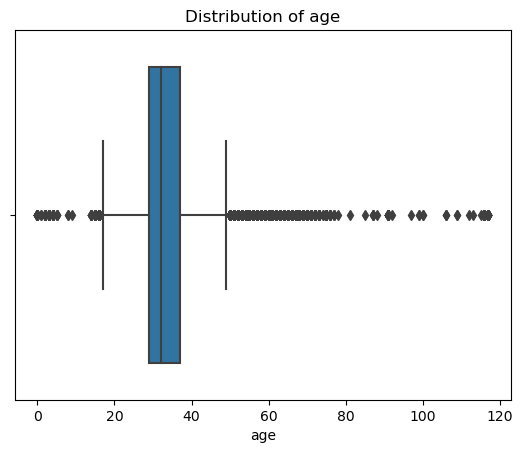

In [28]:
sns.boxplot(x= df['age'])
plt.title('Distribution of age')
plt.show()

In [29]:
Q1 = df['age'].quantile(0.25) 
Q3 = df['age'].quantile(0.75)

IQR = Q3 -Q1

lower_whisker = Q1 - (1.5*IQR)
upper_whisker = Q3 + (1.5*IQR)

print("lower bound : ", lower_whisker)
print("upper bound : ", upper_whisker)

df['age'].where(df['age'] <= upper_whisker, upper_whisker, inplace=True)
df['age'].where(df['age'] >= lower_whisker, lower_whisker, inplace=True)

outliers = df[(df['age'] < lower_whisker) | (df['age']> upper_whisker)]

outliers['age']

lower bound :  17.0
upper bound :  49.0


Series([], Name: age, dtype: float64)

In [34]:
print("DATA without Outliers :")
df.head()

DATA without Outliers :


,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,fit,34d,137.000000,10.0,vacation,hourglass,romper,68.0,14,28.0
1,fit,34b,132.000000,10.0,other,straight & narrow,gown,66.0,12,36.0
2,fit,34b,137.391709,10.0,party,hourglass,sheath,64.0,4,49.0
3,fit,34c,135.000000,8.0,formal affair,pear,dress,65.0,8,34.0
4,fit,34b,145.000000,10.0,wedding,athletic,gown,69.0,12,27.0


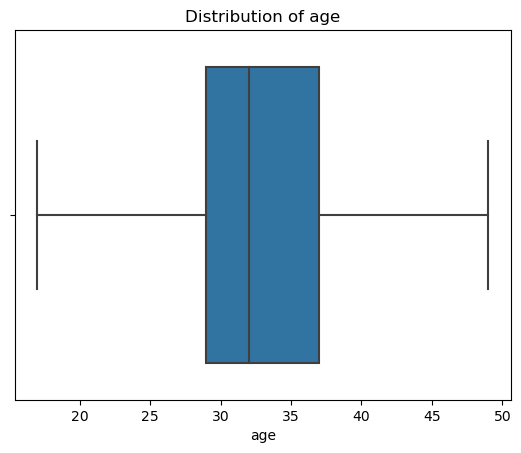

In [33]:
sns.boxplot(x= df['age'])
plt.title('Distribution of age')
plt.show()

### 11. Check the distribution of the different categories in the column 'rented for' using appropriate plot. (2)


In [35]:
# checking column
pd.DataFrame(df['rented for'])

,rented for
0,vacation
1,other
2,party
3,formal affair
4,wedding
...,...
192539,work
192540,work
192541,everyday
192542,wedding


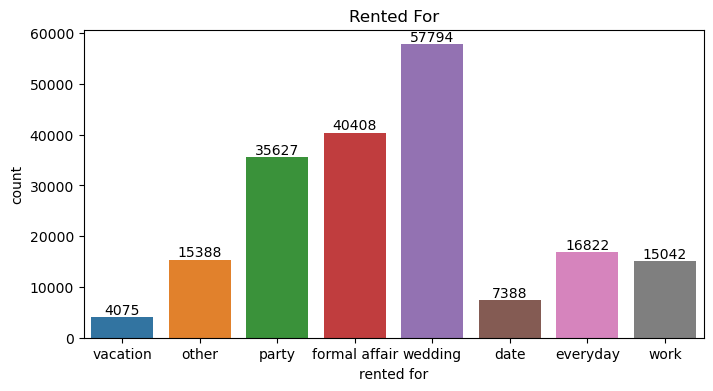

In [39]:
#plotting the distribution using bar plot

plt.figure(figsize=(8,4))
rented_for = sns.countplot(x='rented for', data= df)
plt.title("Rented For")
plt.xlabel("rented for")
plt.ylabel('count')
plt.bar_label(rented_for.containers[0])
plt.show()

- From above shown plot , It is observed that -
- customers rent outfits mostly for 'weddings' followed by 'formal affair' and 'party'
- The number of customers who rented for weddings are 57794 which is highest of total categories
- the least rented category is 'vacation'

## ● Data Preparation for model building:

###  12. Encode the categorical variables in the dataset. (1)



In [40]:
# checking categorical columns
df_cat = df.select_dtypes(include='object')
df_cat

,fit,bust size,rented for,body type,category
0,fit,34d,vacation,hourglass,romper
1,fit,34b,other,straight & narrow,gown
2,fit,34b,party,hourglass,sheath
3,fit,34c,formal affair,pear,dress
4,fit,34b,wedding,athletic,gown
...,...,...,...,...,...
192539,fit,34dd,work,hourglass,jumpsuit
192540,fit,32c,work,petite,dress
192541,fit,36a,everyday,straight & narrow,dress
192542,fit,36c,wedding,pear,dress


In [42]:
le = LabelEncoder()
for col in df_cat:
    df[col] = le.fit_transform(df[col])
    


In [44]:
df.head()

,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,0,39,137.000000,10.0,5,3,44,68.0,14,28.0
1,0,37,132.000000,10.0,3,6,20,66.0,12,36.0
2,0,37,137.391709,10.0,4,3,45,64.0,4,49.0
3,0,38,135.000000,8.0,2,4,16,65.0,8,34.0
4,0,37,145.000000,10.0,6,1,20,69.0,12,27.0


In [45]:
#copying dataset beforing scaling and certain no. of data because it's giving me memory error
df_copy = df.copy()

### 13. Standardize the data, so that the values are within a particular range. (1)

In [46]:
## Standardization
sc = StandardScaler()
scaled_features = sc.fit_transform(df_copy.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df_copy.index, columns=df_copy.columns)

In [47]:
scaled_features_df.head()

,fit,bust size,weight,rating,rented for,body type,category,height,size,age
0,-0.556291,-0.004640,-1.946601e-02,0.634822,0.514420,0.020953,1.569310,1.011506,0.206575,-0.793484
1,-0.556291,-0.187210,-2.679414e-01,0.634822,-0.456753,1.927582,-0.307247,0.259283,-0.028862,0.357032
2,-0.556291,-0.187210,-1.412419e-15,0.634822,0.028833,0.020953,1.647500,-0.492940,-0.970608,2.226620
3,-0.556291,-0.095925,-1.188562e-01,-0.764037,-0.942340,0.656496,-0.620006,-0.116828,-0.499735,0.069403
4,-0.556291,-0.187210,3.780946e-01,0.634822,1.000007,-1.250132,-0.307247,1.387617,-0.028862,-0.937299


## ● Principal Component Analysis and Clustering:

### 14. Apply PCA on the above dataset and determine the number of PCA components to be used so that 90-95% of the variance in data is explained by the same. (7)

In [48]:
## Calculating covariance matrix
cov_matrices = np.cov(scaled_features_df.T)
print(cov_matrices)

[[ 1.00000519e+00  9.05525666e-03  1.34138344e-02 -2.45017128e-01
   8.35378787e-03 -7.61016810e-03  3.35892077e-04  1.56520435e-04
   6.54006939e-02  8.67163272e-04]
 [ 9.05525666e-03  1.00000519e+00  5.74163260e-01 -2.09463072e-02
  -2.07814670e-03 -2.15702411e-01 -1.09647683e-02  1.47029967e-01
   6.27115858e-01  1.72328174e-01]
 [ 1.34138344e-02  5.74163260e-01  1.00000519e+00 -2.06828900e-02
   9.91868005e-03 -2.35893510e-01 -1.48283310e-02  3.50844864e-01
   7.32740552e-01  6.92435782e-02]
 [-2.45017128e-01 -2.09463072e-02 -2.06828900e-02  1.00000519e+00
   1.28842617e-02  4.73487321e-03 -2.36044968e-02  1.74189843e-03
  -3.67259761e-02 -4.13739940e-02]
 [ 8.35378787e-03 -2.07814670e-03  9.91868005e-03  1.28842617e-02
   1.00000519e+00 -9.08626233e-03 -5.76351186e-02 -1.70417833e-02
   4.87422452e-03 -3.73073385e-02]
 [-7.61016810e-03 -2.15702411e-01 -2.35893510e-01  4.73487321e-03
  -9.08626233e-03  1.00000519e+00 -1.85295641e-03 -1.33606364e-01
  -2.14155816e-01 -4.70891167e-02

In [49]:
## Calculating eigen values and eigen vectors

eig_vals, eig_vecs = np.linalg.eig(cov_matrices)
print("eigen values: ", eig_vals)
print("\neigen vectors: ", eig_vecs)

eigen values:  [2.56178657 0.24744002 0.41538331 1.24962785 0.75078491 1.08444447
 1.01619028 0.83927314 0.94520597 0.88991541]

eigen vectors:  [[-3.74896748e-02 -5.13203835e-02  3.77692240e-02 -6.85724708e-01
  -6.89596896e-01  1.87789980e-01 -7.04079109e-02  8.85222690e-02
  -2.65978703e-02 -2.44631881e-03]
 [-4.96014767e-01 -8.75107795e-02  7.93249422e-01  1.78310787e-02
   5.10693179e-02 -7.37450391e-02  1.86071495e-01  2.39664150e-01
   6.90766312e-03 -1.28813791e-01]
 [-5.44398655e-01 -6.80290316e-01 -4.37028662e-01  5.30840299e-02
   3.95051022e-02  7.33686024e-02 -8.20403660e-02  5.16115248e-02
  -1.04164313e-02 -1.74862077e-01]
 [ 3.66733705e-02 -7.14082744e-03 -2.46882554e-04  6.99940833e-01
  -7.01319469e-01 -4.66032577e-02  3.84446579e-02  1.05350425e-01
   2.28423405e-02 -3.95917146e-02]
 [ 1.60905073e-04  3.29519406e-03  1.46973520e-02  4.86541859e-02
   2.21534860e-02  5.95702419e-01  3.78215342e-01 -2.18451032e-01
   6.68901371e-01 -6.21046064e-02]
 [ 2.53202045e-01 -1

In [50]:
#Calculating the variance explained 
total_eig_values = sum(eig_vals)
var_exp = [(i/total_eig_values)*100 for i in sorted(eig_vals, reverse=True)]

#calculating the cummulative variance explained
cum_var_exp = np.cumsum(var_exp)
print("variance explained : \n\n", var_exp)
print("\nCummulative variance explained : \n\n ", cum_var_exp)

variance explained : 

 [25.617732627455325, 12.496213644979798, 10.844388364097204, 10.16185001894154, 9.452010625650555, 8.899107913272644, 8.392687843484389, 7.507810076479727, 4.153811497415668, 2.4743873882231435]

Cummulative variance explained : 

  [ 25.61773263  38.11394627  48.95833464  59.12018466  68.57219528
  77.47130319  85.86399104  93.37180111  97.52561261 100.        ]


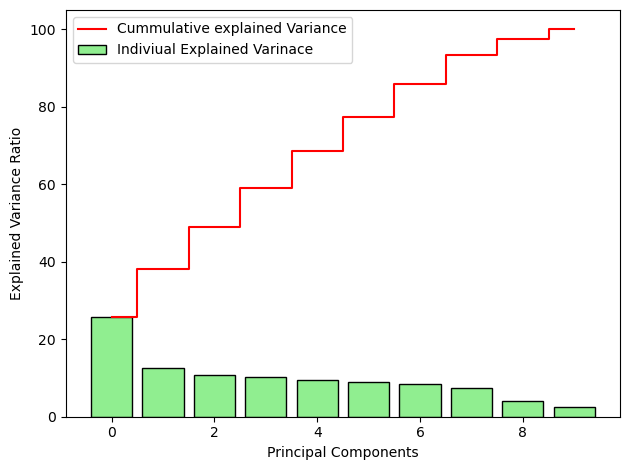

In [51]:
## Scree plot

plt.bar(range(10), var_exp, align='center',color='lightgreen',edgecolor='black',label='Indiviual Explained Varinace')
plt.step(range(10), cum_var_exp, where='mid',color='red',label='Cummulative explained Variance')
plt.legend(loc = 'best')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()

In [52]:
## Fitting the PCA model
pca=PCA(n_components = 8)
pca.fit(scaled_features_df)

PCA(n_components=8)

In [53]:
data_pca = pca.transform(scaled_features_df)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.198201,-0.885675,0.137245,1.327114,1.414393,0.494642,-0.347041,-0.076969
1,-0.663504,-0.707950,0.478966,-0.324248,-0.856483,1.583685,-0.679542,-0.156635
2,-0.502770,-0.383140,2.217198,-0.947447,1.194638,-0.347250,-0.954040,-0.412355
3,-0.560531,0.190123,0.370611,-0.029425,-1.176387,0.281630,-0.113837,0.918359
4,0.613777,-1.224965,-1.451900,0.972864,0.570536,-0.898769,-0.535219,0.022765


### 15. Apply K-means clustering and segment the data. (You may use original data or PCA transformed data) (8)

a. Find the optimal K Value using elbow plot for K Means clustering.

b. Build a Kmeans clustering model using the obtained optimal K value from the elbow plot. 

c. Compute silhouette score for evaluating the quality of the K Means clustering technique.

In [54]:
cluster_range = range(1,10)
cluster_errors = []

for num_clusters in cluster_range:
   
    clusters = KMeans(num_clusters, n_init=9)
    clusters.fit(data_pca)
    
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({'num_clusters':cluster_range, 
                           'cluster_errors':cluster_errors})

clusters_df

,num_clusters,cluster_errors
0,1,1.797818e+06
1,2,1.496636e+06
2,3,1.358796e+06
3,4,1.249634e+06
4,5,1.155518e+06
5,6,1.095886e+06
6,7,1.041171e+06
7,8,9.928005e+05
8,9,9.597238e+05


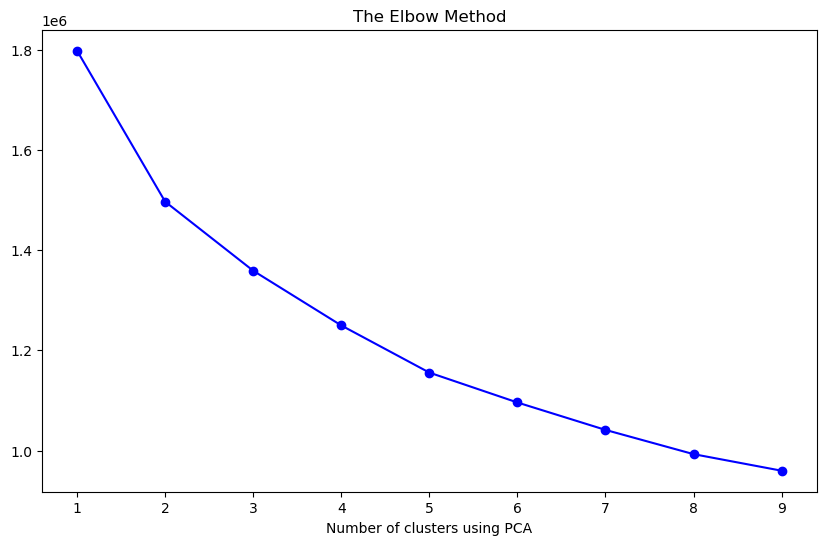

In [55]:
## Elbow method
plt.figure(figsize=[10,6])
plt.title('The Elbow Method')
plt.xlabel('Number of clusters using PCA')
plt.plot(clusters_df['num_clusters'],clusters_df['cluster_errors'],marker='o',color='b')
plt.show()

In [56]:
## Fit the KMeans clustering model using the obtained optimal K
kmeans = KMeans(n_clusters=2, n_init=10, random_state=2345)
kmeans.fit(data_pca)

KMeans(n_clusters=2, n_init=10, random_state=2345)

In [57]:
## obtained labels from kmeans clustering
kmeans.labels_

array([1, 1, 1, ..., 1, 0, 0])

In [58]:
## Creating a new dataframe only for labels.
df_labels = pd.DataFrame(kmeans.labels_, columns=list(['Labels']))
df_labels.head(5)

,Labels
0,1
1,1
2,1
3,1
4,0


In [59]:
kmeans_df = data_pca.join(df_labels)
kmeans_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Labels
0,0.198201,-0.885675,0.137245,1.327114,1.414393,0.494642,-0.347041,-0.076969,1
1,-0.663504,-0.707950,0.478966,-0.324248,-0.856483,1.583685,-0.679542,-0.156635,1
2,-0.502770,-0.383140,2.217198,-0.947447,1.194638,-0.347250,-0.954040,-0.412355,1
3,-0.560531,0.190123,0.370611,-0.029425,-1.176387,0.281630,-0.113837,0.918359,1
4,0.613777,-1.224965,-1.451900,0.972864,0.570536,-0.898769,-0.535219,0.022765,0


In [60]:
kmeans_df["Labels"].value_counts(normalize=True)*100

1    60.330626
0    39.669374
Name: Labels, dtype: float64

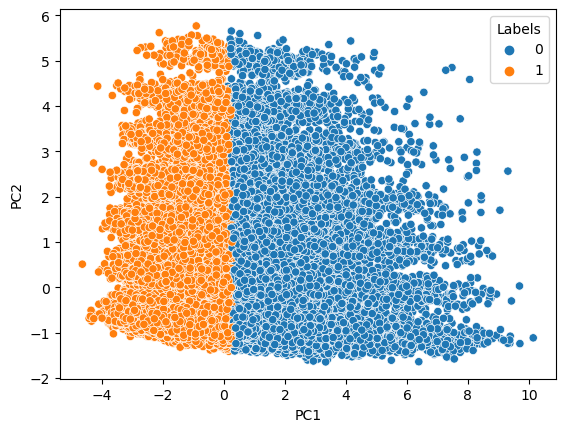

In [68]:
sns.scatterplot( x=kmeans_df['PC1'], y=kmeans_df['PC2'], hue='Labels' , data=kmeans_df)
plt.show()

In [69]:
# Compute silhouette score for evaluating the quality of the K Means clustering technique.
from sklearn.metrics import silhouette_score

kmeans_score = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans = kmeans.fit(data_pca)
    labels = kmeans.predict(data_pca)
    print(i,silhouette_score(data_pca,labels))

2 0.16120489134486196
3 0.16125200023155098
4 0.12637749585107613
5 0.1339691451428127
6 0.11972826465121028
7 0.12712498222440202
8 0.12653712219605895
9 0.11502951015870484


- highest silhoutte score - 0.161252 (3rd cluster)
- Choosing k= 3 as the optimal cluster size and building an agglomerative clustering model using the original scaled dataset

### 16. Apply Agglomerative clustering and segment the data. (You may use original data or PCA transformed data)

a. Find the optimal K Value using dendrogram for Agglomerative clustering.

b. Build a Agglomerative clustering model using the obtained optimal K value observed from dendrogram. 

c. Compute silhouette score for evaluating the quality of the Agglomerative clustering technique. (Hint: Take a sample of the dataset for agglomerative clustering to reduce the computational time)

In [72]:
scaled_features_sample = scaled_features[:10000:]

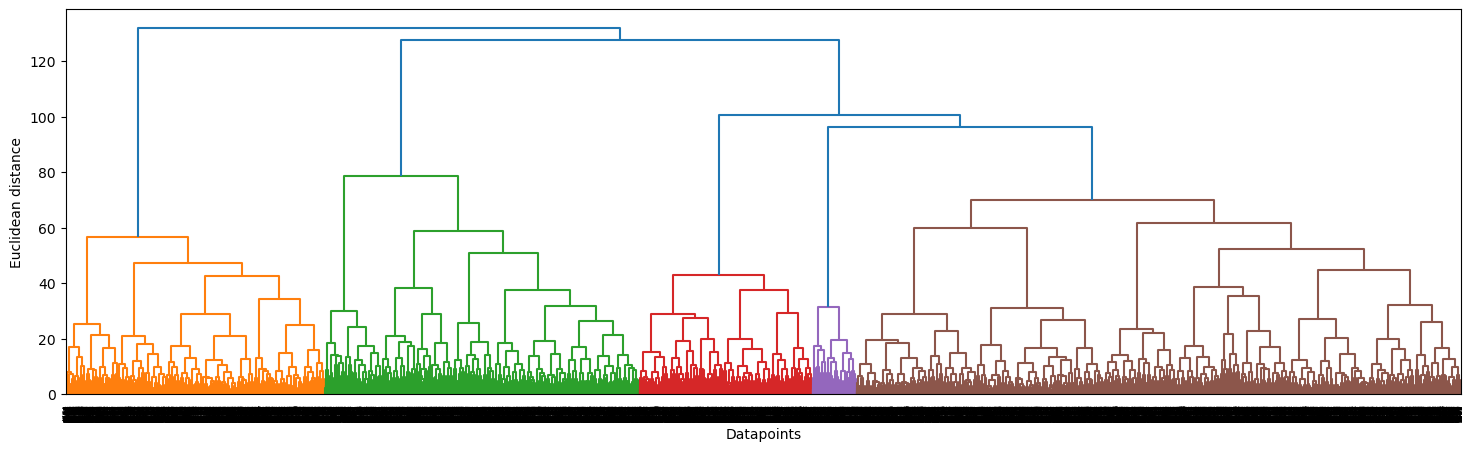

In [73]:
plt.figure(figsize=[18,5])
merg = linkage(scaled_features_sample, method='ward')
dendrogram(merg, leaf_rotation=90,)
plt.xlabel('Datapoints')
plt.ylabel('Euclidean distance')
plt.show()

In [76]:
 
for i in range(2,15):
    hier = AgglomerativeClustering(n_clusters=i)
    hier = hier.fit(data_pca.head(10000))
    labels = hier.fit_predict(data_pca.head(10000))
    print(i,silhouette_score(data_pca.head(10000),labels))

2 0.11021987302788257
3 0.10296320803147442
4 0.1074524934018275
5 0.07538949667509687
6 0.07535642207652865
7 0.08563408439744888
8 0.07658037408483105
9 0.06030391799182885
10 0.06514445866875349
11 0.06473408160765332
12 0.07019356456144926
13 0.061090607562315685
14 0.06059762085593293


In [78]:
hie_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
hie_cluster_model = hie_cluster.fit(data_pca.head(10000))

In [80]:
df_label = pd.DataFrame(hie_cluster_model.labels_, columns=['Labels'])
df_label.head()

,Labels
0,0
1,0
2,0
3,0
4,0


In [81]:
df_hier = df_copy.join(df_label)
df_hier.head()

,fit,bust size,weight,rating,rented for,body type,category,height,size,age,Labels
0,0,39,137.000000,10.0,5,3,44,68.0,14,28.0,0.0
1,0,37,132.000000,10.0,3,6,20,66.0,12,36.0,0.0
2,0,37,137.391709,10.0,4,3,45,64.0,4,49.0,0.0
3,0,38,135.000000,8.0,2,4,16,65.0,8,34.0,0.0
4,0,37,145.000000,10.0,6,1,20,69.0,12,27.0,0.0


In [82]:
scaled_features_df_sample = scaled_features_df.head(10000)

for i in range(2,15):
    hier = AgglomerativeClustering(n_clusters = i)
    hier = hier.fit(scaled_features_df_sample)
    labels = hier.fit_predict(scaled_features_df_sample)
    print(i, silhouette_score(scaled_features_df_sample, labels))


2 0.08688717436441665
3 0.09987182324091935
4 0.09662713717193722
5 0.09867376281806567
6 0.10852306495144173
7 0.05450318732903717
8 0.052770663946782176
9 0.032191653960290105
10 0.038655626232495154
11 0.0432888160851652
12 0.043749005336480074
13 0.04968562044409822
14 0.051612012138211094


- From above Silhoutte scores, the score is highest for cluster 6.

### ● Conclusion : [ Score: 2 point ]


###### 17. Perform cluster analysis by doing bivariate analysis between cluster labels and different features and write your conclusion on the results. (2)

In [83]:
df_hier = df_copy.join(df_label)
df_hier.head()

,fit,bust size,weight,rating,rented for,body type,category,height,size,age,Labels
0,0,39,137.000000,10.0,5,3,44,68.0,14,28.0,0.0
1,0,37,132.000000,10.0,3,6,20,66.0,12,36.0,0.0
2,0,37,137.391709,10.0,4,3,45,64.0,4,49.0,0.0
3,0,38,135.000000,8.0,2,4,16,65.0,8,34.0,0.0
4,0,37,145.000000,10.0,6,1,20,69.0,12,27.0,0.0


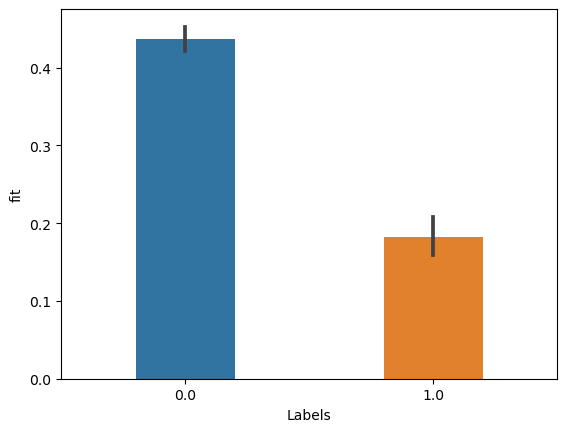

In [86]:
sns.barplot(x=df_hier['Labels'],y=df_hier['fit'], width=0.4)
plt.show()

 -  customers of cluster 0.0 have fit feedback more than cluster 1.0 .

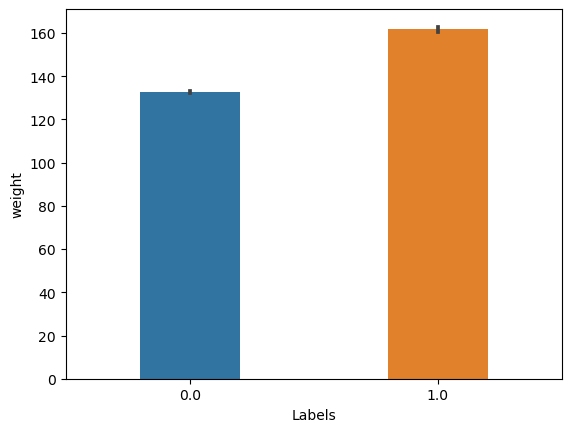

In [87]:
sns.barplot(x=df_hier['Labels'],y =df_hier['weight'], width=0.4 )
plt.show()

- The weight of customers in cluster 0.0 is less than cluster 1.0.

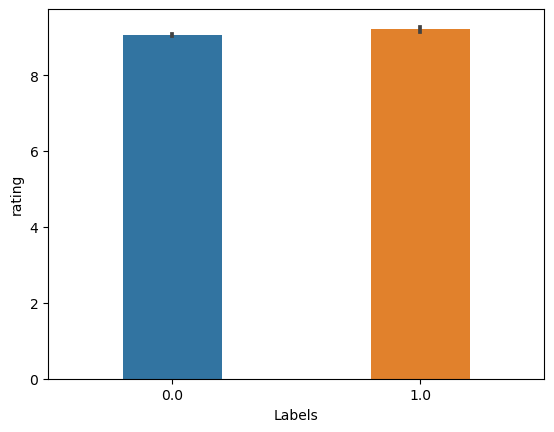

In [89]:
sns.barplot(x= df_hier['Labels'],y=df_hier['rating'], width=0.4)
plt.show()

- The rating provided by customers is approximately the same in cluster 0.0 & 1.0.

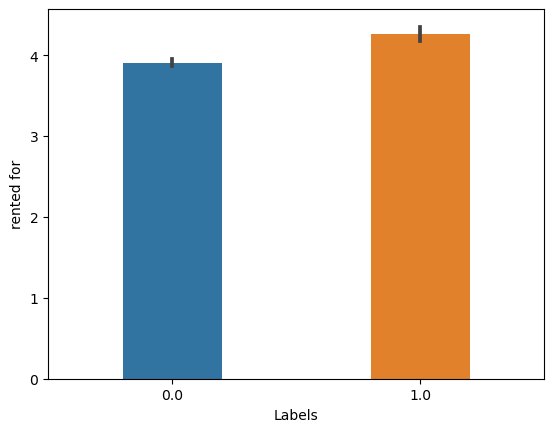

In [90]:
sns.barplot(x=df_hier['Labels'],y=df_hier['rented for'], width=0.4)
plt.show()

- Customers who rented clothes in cluster 0.0 is lesser than those of cluster 1.0

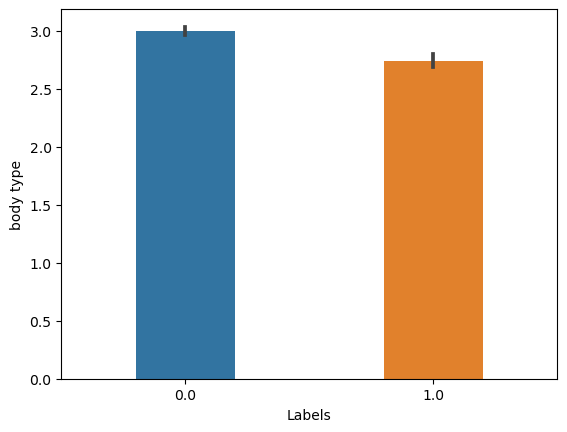

In [91]:
sns.barplot(x=df_hier['Labels'],y=df_hier['body type'], width=0.4)
plt.show()

- The body type in cluster 0.0 is more than in cluster 1.0.

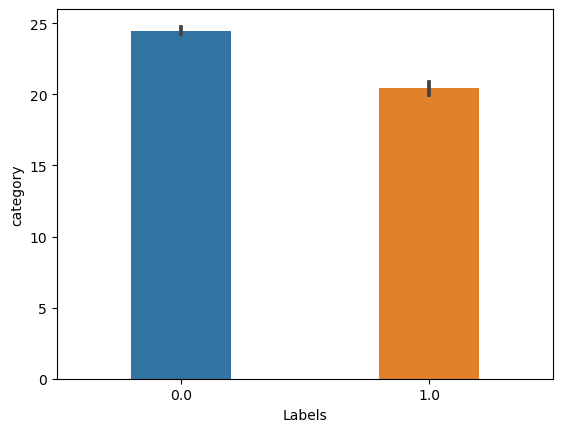

In [92]:
sns.barplot(x=df_hier['Labels'],y=df_hier['category'], width=0.4)
plt.show()

- There are more categories in cluster 0.0 than in cluster 1.0.

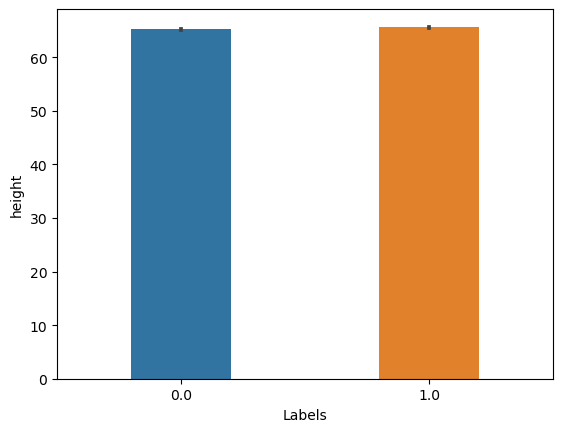

In [93]:
sns.barplot(x=df_hier['Labels'],y=df_hier['height'], width=0.4)
plt.show()

- The heights of the customers in both cluster is approximately the same.

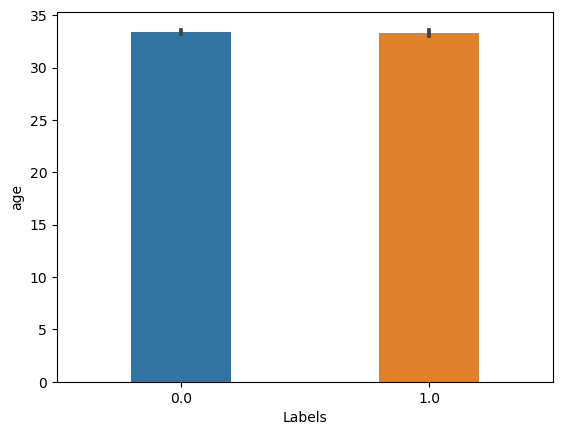

In [94]:
sns.barplot(x=df_hier['Labels'],y=df_hier['age'], width=0.4)
plt.show()

- The age of customers in clusters is same

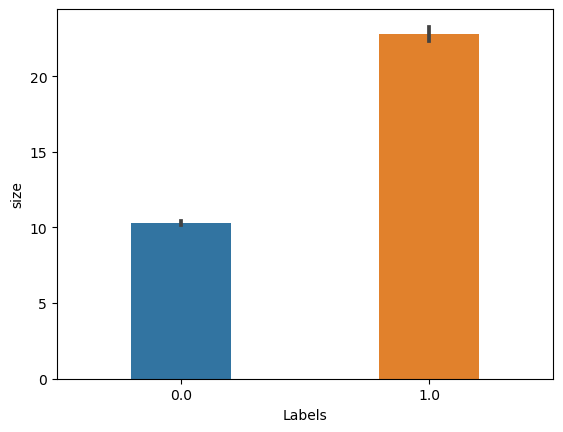

In [95]:
sns.barplot(x=df_hier['Labels'],y=df_hier['size'], width=0.4)
plt.show()

- The size of products in cluster 1.0 is larger than cluster 0.0 .

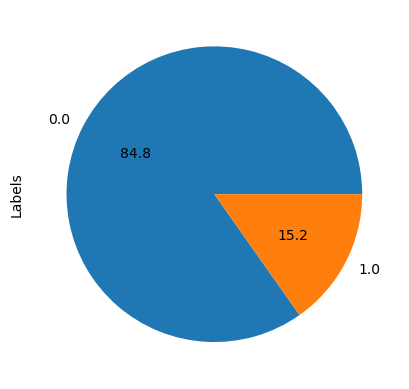

In [96]:
df_hier['Labels'].value_counts().plot(kind='pie',autopct='%0.1f')
plt.show()

-  The clusters formed are imbalanced. There are more number of records of cluster 0 than that of cluster 1.

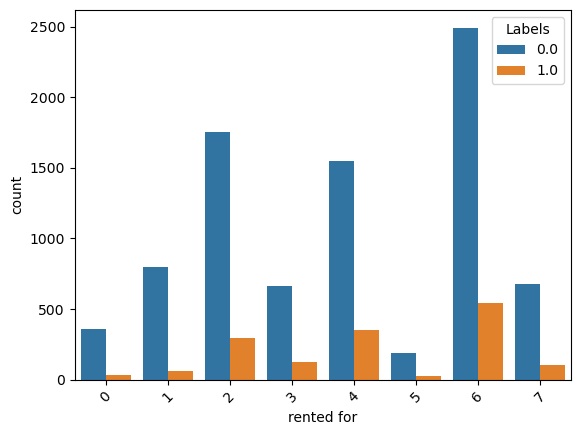

In [99]:
sns.countplot(x=df['rented for'],hue='Labels',data=df_hier)
plt.xticks(rotation = 45)
plt.show()

- From the above plot it is observed that there are more number of users who have rented the product is for 'wedding'.
- cluster 0 is larger than cluster 1 in "Wedding".

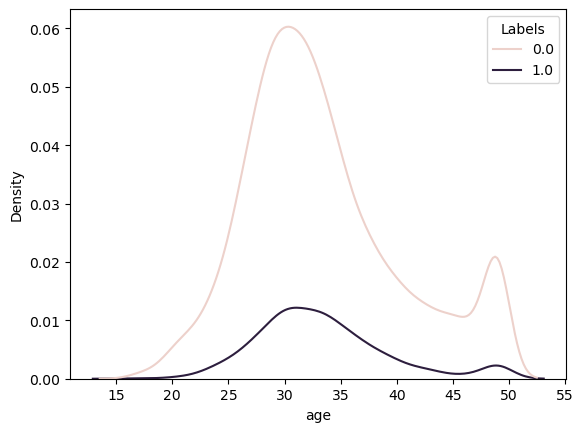

In [100]:
## Lets check the age distribution of the different clusters.
sns.kdeplot(x=df_hier['age'],hue='Labels',data=df_hier)
plt.show()

- The distribution of the age for different clusters is almost same, but there are more number of observations assigned to the cluster 0.

- In this project, we implemented PCA on the 'renttherunway' dataset and selected 8 PCA compoments, which gave us the 90-95% of the variance in the data.

- Time of computation is more than 20 minutes, should be taken into consideration for getting the final result.